In [41]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [42]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [43]:
# load data

train_set = datasets.MNIST(root='data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor()
                             )

test_set = datasets.MNIST(root='data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor()
                            )

# make a validation set

train_length = len(train_set)
train_size = int(train_length * 0.85)
val_size = train_length - train_size

train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

# store train and val loss
train_loss_list = []
val_loss_list = []
epoch_list = []
train_acc_list = []
val_acc_list = []


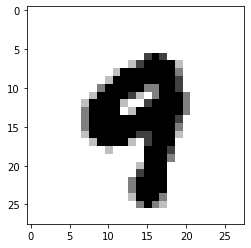

In [44]:
plt.figure(1)
img, label = train_set[7]
plt.imshow(img.squeeze(), cmap='binary')

In [45]:
img.size()

torch.Size([1, 28, 28])

In [46]:
# network architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(64*7*7,128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 64*7*7)
        out = self.layer3(out)
        return out


In [47]:
# training loop

def train_loop(epochs, optimizer, model, loss_fn, train_loader, val_loader):

    for epoch in range(1, epochs+1):
        loss_train = 0.0
        correct = 0
        total = 0

        for imgs, labels in train_loader:

            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted==labels).sum())

            train_correct = correct
            train_total = total

        epoch_list.append(epoch)
        train_loss_list.append(loss_train)

        # test on validation data
        # get loss of validation data
        with torch.no_grad():
            loss_val = 0.0
            correct = 0
            total = 0
            for imgs, labels in val_loader:
                # move tensors to gpu if available
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)

                outputs = model(imgs)

                loss_v = loss_fn(outputs, labels)

                loss_val += loss_v.item()

                _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
            total += labels.shape[0]  # Counts the number of examples, so total is increased by the batch size
            correct += int((predicted == labels).sum())
            val_correct = correct
            val_total = total


        val_loss_list.append(loss_val / len(val_loader))

        train_acc_list.append(train_correct/train_total)
        val_acc_list.append(val_correct/val_total)

        # set when to print info about training progress
        if epoch == 1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {:.3f}, Validation loss {:.3f}, Train Acc {:.3f}, Val Acc {:.3f}'.format(epoch, loss_train / len(train_loader), loss_val / len(val_loader), train_correct/train_total, val_correct/val_total),
                  )

def test_loop(model, test_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in test_loader:

            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
            total += labels.shape[0]  # Counts the number of examples, so total is increased by the batch size
            correct += int((predicted == labels).sum())


    print("Accuracy test: {:.3f} %".format(100 *  (correct / total)))

In [48]:
epochs = 10
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
# epoch_num_of_no_improve = 5

train_loop(
    epochs = epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader)

test_loop(model, test_loader)

Epoch 1, Training loss 1.588, Validation loss 1.499, Train Acc 0.875, Val Acc 1.000
Epoch 2, Training loss 1.485, Validation loss 1.500, Train Acc 0.976, Val Acc 1.000
Epoch 3, Training loss 1.480, Validation loss 1.485, Train Acc 0.982, Val Acc 1.000
Epoch 4, Training loss 1.477, Validation loss 1.483, Train Acc 0.984, Val Acc 1.000
Epoch 5, Training loss 1.476, Validation loss 1.483, Train Acc 0.985, Val Acc 1.000
Epoch 6, Training loss 1.476, Validation loss 1.479, Train Acc 0.986, Val Acc 1.000
Epoch 7, Training loss 1.474, Validation loss 1.477, Train Acc 0.988, Val Acc 1.000
Epoch 8, Training loss 1.473, Validation loss 1.476, Train Acc 0.989, Val Acc 1.000
Epoch 9, Training loss 1.473, Validation loss 1.477, Train Acc 0.988, Val Acc 1.000
Epoch 10, Training loss 1.473, Validation loss 1.479, Train Acc 0.988, Val Acc 1.000
Accuracy test: 98.420 %


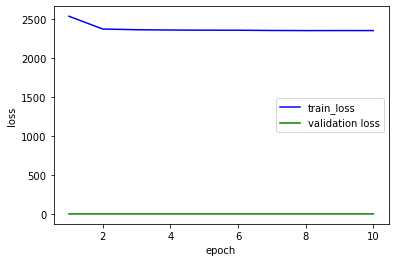

In [49]:
plt.figure(2)
plt.plot(epoch_list, train_loss_list, color='blue', label='train_loss')
plt.plot(epoch_list, val_loss_list, color='green', label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

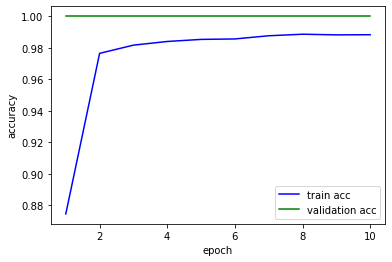

In [50]:
plt.figure(3)
plt.plot(epoch_list, train_acc_list, color='blue', label='train acc')
plt.plot(epoch_list, val_acc_list, color='green', label='validation acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

Text(230.20000000000005, 0.5, 'predicted label')

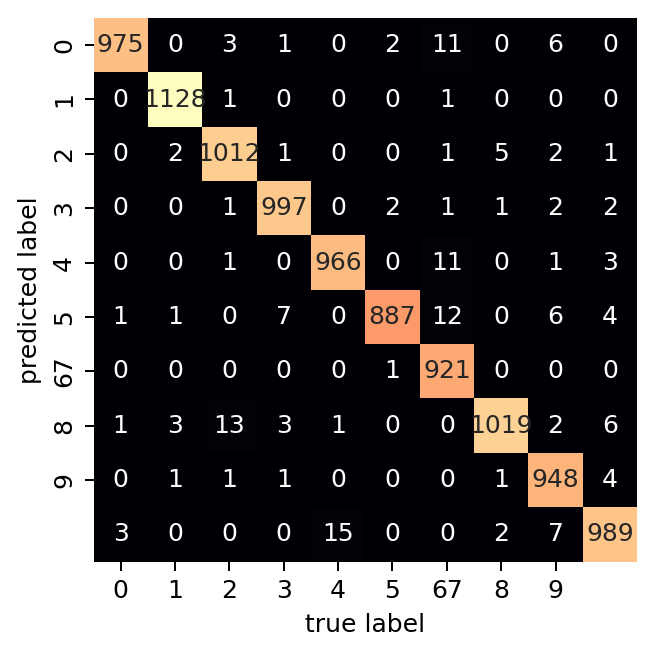

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
y_fit = np.array([])
y_test = np.array([])

for imgs, labels in test_loader:
    model = model.to('cpu')

    outputs = model(imgs)

    _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
    predicted = predicted.detach().numpy()
    labels = labels.detach().numpy()
    y_fit = np.concatenate((y_fit, predicted), axis=None)
    y_test = np.concatenate((y_test, labels), axis=None)
    # y_fit.append(predicted)
    # y_test.append(labels)

labels_names = ['0', '1', '2', '3', '4', '5', '6' '7', '8', '9']

plt.figure(6, dpi=180)
conf_matrix = confusion_matrix(y_test, y_fit)
conf_matrix = pd.DataFrame(conf_matrix)
sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels_names, yticklabels=labels_names, cmap='magma')
plt.xlabel('true label')
plt.ylabel('predicted label')